In [1]:
import os, json
import torch


dir = '/work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_56/interim_results'

In [2]:
for file in os.listdir(dir):
    if file.endswith('.json'):
        path = os.path.join(dir, file)
        try:
            with open(path, 'r') as f:
                data = json.load(f)
            if not isinstance(data, dict) or not data:  # Leer oder kein Dict
                print("⚠️ Leer/unklar:", file)
        except Exception as e:
            print("❌ Fehler in", file, "->", e)

        
for root, dirs, files in os.walk(dir):
    for file in files:
        if file.endswith('.ckpt'):
            path = os.path.join(root, file)
            try:
                ckpt = torch.load(path, map_location='cpu')
            except Exception as e:
                print("❌ Fehlerhafter Checkpoint:", path, "->", e)


In [3]:
from ray.tune import ExperimentAnalysis

exp_dir = "/work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_56/"
analysis = ExperimentAnalysis(exp_dir)
for trial in analysis.trials:
    res = trial.last_result if hasattr(trial, "last_result") else {}
    if "silhouette" not in res:
        print(f"⚠️ Trial {trial.trial_id} fehlt silhouette!")


/work/aa0238/a271125/conda/envs/MA/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


⚠️ Trial 8ebb2db6 fehlt silhouette!
⚠️ Trial a8c389b7 fehlt silhouette!
⚠️ Trial e0dd77a2 fehlt silhouette!


In [4]:
#import json
#
#path = "/work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_56/vae_gmm_scan_v56/experiment_state-2025-06-27_12-05-50.json"
#with open(path, "r") as f:
#    state = json.load(f)
#
## Entferne alle Einträge mit trial_id d1b489d4
#state["trials"] = [t for t in state.get("trials", []) if t.get("trial_id") != ""]
#
#with open(path, "w") as f:
#    json.dump(state, f, indent=2)
#
#
#import json
#
#path = "/work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_56/vae_gmm_scan_v56/search_gen_state-2025-06-27_12-05-50.json"
#with open(path, "r") as f:
#    gen = json.load(f)
#
## Falls trial_ids darin auftauchen, ebenfalls filtern
#gen["generated"] = [g for g in gen.get("generated", []) if g.get("trial_id") != ""]
#
#with open(path, "w") as f:
#    json.dump(gen, f, indent=2)
#
#

Höchster Silhouette-Score: 0.2683


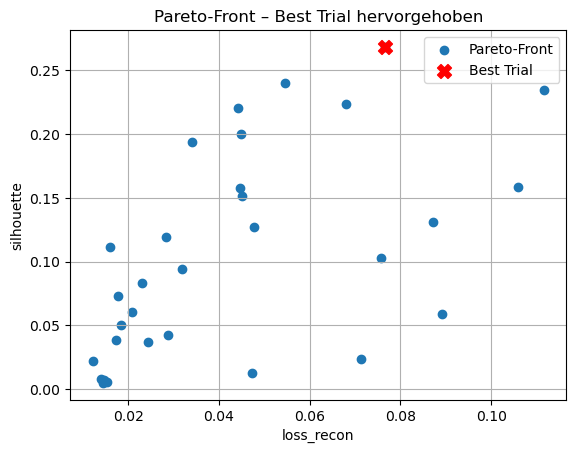

<Figure size 640x480 with 0 Axes>

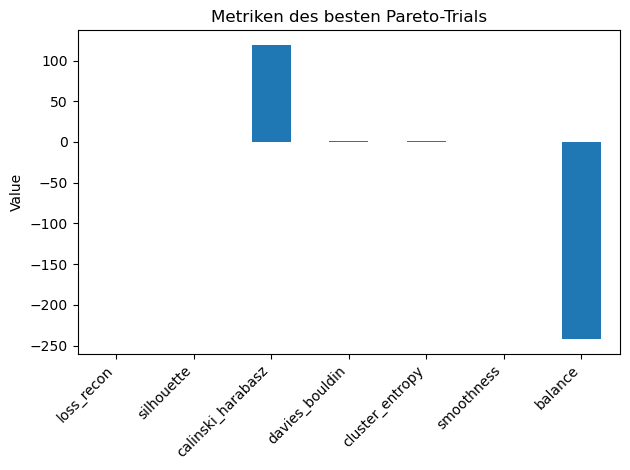

,Config Value
vae_lr,0.0021171572
clustering_lr,0.0002261711
recon_weight,0.5991992901
vae_end_value,0.0000337488
gmm_end_value,0.0086850862
reg_end_value,0.2607213578
cat_end_value,0.0261208949
vae_lr_factor,0.7596144585
vae_lr_patience,20.0000000000
latent_dim,20.0000000000


In [12]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import glob

# ==== Pfade anpassen ====
#metrics_dir = Path("/work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_59/interim_results")
metrics_dir = Path("/work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_67/interim_results")

#print(glob.glob(str(metrics_dir / "trial_*.json")))

# ==== JSON-Dateien einlesen ====
pareto = []
for tf in metrics_dir.glob("trial_*.json"):
    trial = json.loads(tf.read_text(encoding="utf-8"))
    config = trial.get('config', {})
    trial_id = trial.get('trial_id', tf.stem)
    metrics = trial.get('metrics', {})
    # Alles auf Top-Level
    row = dict(trial_id=trial_id, **config, **metrics)
    pareto.append(row)

df = pd.DataFrame(pareto)
#print("Verfügbare Spalten:", df.columns.tolist())
#print(df.head())

# ==== Dynamisches Erkennen der Spaltennamen ====
recon_loss_names = ["loss_recon", "loss", "val_loss", "recon_loss", "total_loss"]
recon_loss_col = next((name for name in recon_loss_names if name in df.columns), None)
if recon_loss_col is None:
    raise ValueError(f"Keine Spalte für Reconstruction Loss gefunden. Bekannte Namen: {recon_loss_names}")

silhouette_names = ["silhouette", "silhouette_score"]
silhouette_col = next((name for name in silhouette_names if name in df.columns), None)
if silhouette_col is None:
    raise ValueError(f"Keine Spalte für Silhouette gefunden. Bekannte Namen: {silhouette_names}")

    
#print("Vor dem Filtern:")
#print(df[[silhouette_col, recon_loss_col]].head(10))
#print(df[[silhouette_col, recon_loss_col]].describe())

# ==== DataFrame filtern ====
df_clean = df[(df[silhouette_col] > -999) & (df[recon_loss_col] < 999)]
#print("Shape nach Filtern:", df_clean.shape)
#
#print("Nach dem Filtern:")
#print(df_clean[[silhouette_col, recon_loss_col]].head(10))
#print(df_clean.shape)
#
# ==== Best Trial nach Silhouette finden ====
best_idx = df_clean[silhouette_col].idxmax()
best = df_clean.loc[best_idx]
print(f"Höchster Silhouette-Score: {best[silhouette_col]:.4f}")

# ==== Pareto-Front Scatter-Plot ====
plt.figure()
plt.scatter(
    df_clean[recon_loss_col], df_clean[silhouette_col],
    label='Pareto-Front'
)
plt.scatter(
    best[recon_loss_col], best[silhouette_col],
    marker='X', s=100, c='red', label='Best Trial'
)
plt.xlabel(recon_loss_col)
plt.ylabel(silhouette_col)
plt.title("Pareto-Front – Best Trial hervorgehoben")
plt.legend()
plt.grid(True)
plt.show()

# ==== Bar-Chart der Metriken des besten Trials ====
metrics_cols = [col for col in df.columns if col not in ["trial_id"] + list(config.keys())]
metrics_for_bar = best[metrics_cols].dropna()
metrics_for_bar = metrics_for_bar.apply(pd.to_numeric, errors='ignore')
# Zeige nur numerische Werte an
metrics_for_bar = metrics_for_bar[metrics_for_bar.apply(lambda x: isinstance(x, (int, float)))]
metrics_df = pd.DataFrame(metrics_for_bar)
metrics_df.columns = ['Value']

plt.figure()
metrics_df.plot(kind='bar', legend=False)
plt.title("Metriken des besten Pareto-Trials")
plt.ylabel("Value")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ==== Konfig-DataFrame des besten Trials anzeigen ====
config_df = pd.DataFrame.from_dict(
    {k: best[k] for k in config.keys()}, 
    orient='index', columns=['Config Value']
)
config_df

In [13]:
# %% Zell 1: Imports und Pfade
import json
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Ordner mit deinen trial_*.json
#metrics_dir = Path("/work/aa0238/a271125/logs_ray/"
#                   "vae_gmm_multi_objective_scan/version_59/interim_results")
#
## Wurzel, unter der alle experiment_state-*.json liegen
#logs_root = Path("/work/aa0238/a271125/logs_ray/"
#                 "vae_gmm_multi_objective_scan/version_59")
#

In [14]:
# %% Zell 3: Alle Metrik-JSONs laden
trials = []
for p in metrics_dir.glob("trial_*.json"):
    tid = p.stem.split("trial_")[1]
    data = json.loads(p.read_text(encoding="utf-8"))
    trials.append({"trial_id": tid, **data})

print(f"Anzahl geladener Trials: {len(trials)}")


Anzahl geladener Trials: 31


In [15]:
df_clean

# Baue Kosten-Matrix: jede Zeile ein Trial, jede Spalte ein Ziel
cost_matrix = np.vstack([
    df_clean["loss_recon"].to_numpy(),
    -df_clean["silhouette"].to_numpy(),
    df_clean["davies_bouldin"].to_numpy(),
    -df_clean["calinski_harabasz"].to_numpy(),
    -df_clean["smoothness"].to_numpy(),
    -df_clean["balance"].to_numpy(),
]).T

# Pareto‐Front berechnen
is_pareto = np.ones(len(cost_matrix), dtype=bool)
for i, c in enumerate(cost_matrix):
    if not is_pareto[i]:
        continue
    # Finde alle j, die von i dominiert werden
    dominated = np.all(cost_matrix <= c, axis=1) & np.any(cost_matrix < c, axis=1)
    is_pareto[dominated] = False

pareto_df = df_clean[is_pareto]
pd.set_option('display.precision', 10)   # z.B. 10 Dezimalstellen anzeigen
pareto_df

,trial_id,vae_lr,clustering_lr,recon_weight,vae_end_value,gmm_end_value,reg_end_value,cat_end_value,vae_lr_factor,vae_lr_patience,latent_dim,gmm_epochs,vae_epochs,loss_recon,silhouette,calinski_harabasz,davies_bouldin,cluster_entropy,smoothness,balance
1,a87bee55,0.0006538786,0.0001398250,0.2854289441,0.0000114407,0.0035754351,0.2238526023,0.0435118774,0.8157062846,20,40,50,30,0.0340856947,0.1934709847,56.0520401001,1.5905592442,1.3927919865,-0.8205540776,-215.6284179688
2,b1b52683,0.0016738536,0.0000541189,0.3857735858,0.0000438682,0.0030112015,0.1039024293,0.0147216923,0.7345496201,20,20,50,30,0.0449157469,0.1996521205,75.6057281494,1.6463826895,1.3595929146,-0.6273615360,-242.1111297607
3,7f0b0d21,0.0000320653,0.0000028935,0.2646814853,0.0069503196,0.0038212559,0.3601937817,0.0358501245,0.7617888602,10,70,80,25,0.0473496169,0.0125413192,5.8208122253,5.5389628410,1.5238901377,-0.6224955916,-108.1062316895
4,1858dc2a,0.0000852540,0.0001026291,0.9469260530,0.0001161566,0.0099265096,0.1477620763,0.0086260021,0.7595090126,30,14,80,30,0.1115775555,0.2340515703,88.2196578979,1.4139953852,1.5848776102,-0.6278785467,-18.9871177673
5,0a863429,0.0033845499,0.0000045431,0.0740904540,0.0019861750,0.0053613496,0.4896633332,0.0018485548,0.8360803860,40,70,150,40,0.0146553833,0.0070357844,4.5840883255,6.4916114807,1.6049367189,-0.6648994684,-7.5058112144
6,d4058d1e,0.0005523337,0.0001174362,0.9168141071,0.0000934929,0.0093077302,0.1564717444,0.0087538422,0.7418970092,30,14,50,30,0.1058982238,0.1585788280,59.7728996277,1.7708615065,1.5358576775,-0.5930243731,-86.0691680908
8,6f46bed8,0.0005687022,0.0000073503,0.1026952053,0.0012635407,0.0033145408,0.1167184247,0.0010431914,0.8148218014,20,30,80,25,0.0174006708,0.0382122435,15.0624666214,3.7256631851,1.3830028772,-0.6360281706,-237.6223602295
9,66678771,0.0000318969,0.0000474322,0.4655827730,0.0041209518,0.0038640653,0.3293638127,0.0015697995,0.7819012036,10,70,150,25,0.0712542534,0.0236081928,9.3116636276,4.4285340309,1.5320848227,-0.6352953315,-38.1541137695
11,bf09d460,0.0010162965,0.0000169934,0.0646198014,0.0046154624,0.0046600531,0.1805155072,0.0139360498,0.8027011686,40,50,150,40,0.0144233517,0.0050674803,4.3757472038,6.9615025520,1.5761398077,-0.6383166909,-22.9039821625
13,45c8065e,0.0019765500,0.0000560531,0.4050479332,0.0000325388,0.0030741444,0.1131664344,0.0213114928,0.7335675104,20,20,50,30,0.0442183204,0.2205683738,96.0146560669,1.6134327650,1.3690010309,-0.6552780867,-240.5970764160


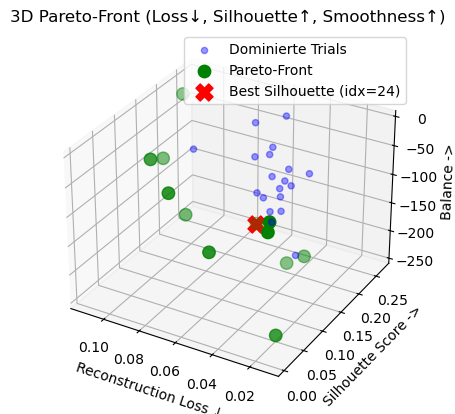

In [16]:
# %% Zell: Pareto‐Front und 3D‐Scatter für drei Ziele

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Annahme: df_clean enthält die Spalten 'loss_recon', 'silhouette', 'smoothness'
loss = df_clean["loss_recon"].to_numpy()
sil  = df_clean["silhouette"].to_numpy()
sm   = df_clean["balance"].to_numpy()

# 1) Kosten‐Matrix: wir wollen alles minimieren → für Max-Ziele nehmen wir das Negative
cost_matrix = np.vstack([
    loss,        # minimieren
    -sil,        # maximieren → minimiere -silhouette
    -sm,         # maximieren → minimiere -smoothness
]).T  # shape (n_trials, 3)

# 2) Pareto‐Front berechnen (Non‐Domination)
is_pareto = np.ones(len(cost_matrix), dtype=bool)
for i, c in enumerate(cost_matrix):
    if not is_pareto[i]:
        continue
    # dominated: alle j für die cost_matrix[j] <= c in allen Zielen
    # und < c in mindestens einem
    dominated = np.all(cost_matrix <= c, axis=1) & np.any(cost_matrix < c, axis=1)
    is_pareto[dominated] = False

# 3) 3D‐Scatter zeichnen
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# (a) dominierte Trials in hellgrau
ax.scatter(
    loss[~is_pareto],
    sil[~is_pareto],
    sm[~is_pareto],
    color="blue",
    alpha=0.4,
    label="Dominierte Trials"
)

# (b) Pareto‐Front in grün
ax.scatter(
    loss[is_pareto],
    sil[is_pareto],
    sm[is_pareto],
    color="green",
    s=80,
    label="Pareto‐Front"
)

# (c) Best‐Silhouette als rotes Kreuz
best_idx = sil.argmax()
ax.scatter(
    loss[best_idx],
    sil[best_idx],
    sm[best_idx],
    color="red",
    marker="X",
    s=150,
    label=f"Best Silhouette (idx={best_idx})"
)

# Labels und Titel
ax.set_xlabel("Reconstruction Loss ↓")
ax.set_ylabel("Silhouette Score ->")
ax.set_zlabel("Balance ->")
ax.set_title("3D Pareto‐Front (Loss↓, Silhouette↑, Smoothness↑)")

# Optional: X‐Achse invertieren, damit links kleinste Loss ist
ax.invert_xaxis()

ax.legend()
plt.show()


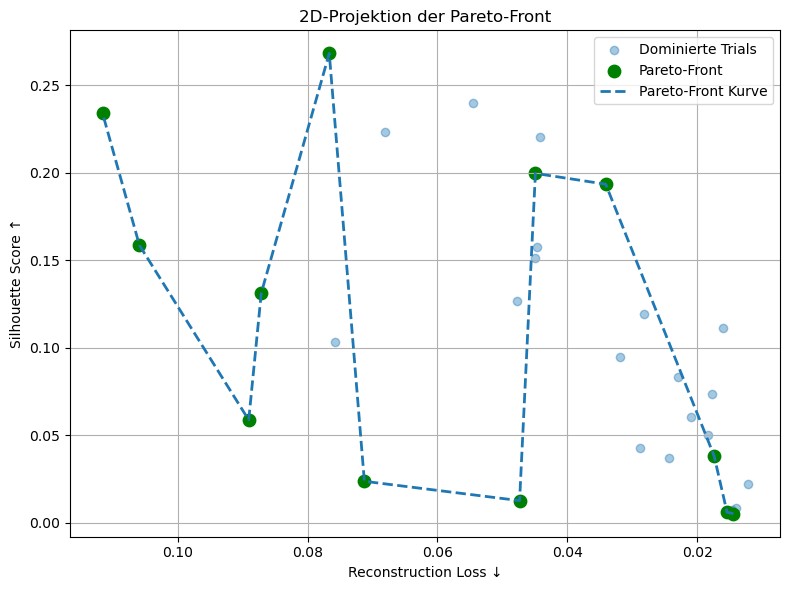

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Aus deinen vorhandenen Arrays:
# loss, sil, sm  (shape jeweils (n_trials,))
# is_pareto      (Boolean‐Array der Länge n_trials)

# 1) Wähle zwei Ziele für die 2D‐Visualisierung:
x = loss           # Reconstruction Loss (→ minimieren)
y = sil            # Silhouette Score (→ maximieren)

# 2) Scatterplot
plt.figure(figsize=(8, 6))

# a) Dominierte Trials
plt.scatter(
    x[~is_pareto],
    y[~is_pareto],
    alpha=0.4,
    label="Dominierte Trials"
)

# b) Pareto‐Front
plt.scatter(
    x[is_pareto],
    y[is_pareto],
    color="green",
    s=80,
    label="Pareto‐Front"
)

# 3) (Optional) Linie durch die Pareto‐Punkte
#    Sortiere erst nach x, damit die Linie nicht kreuzt
pareto_pts = np.vstack([x[is_pareto], y[is_pareto]]).T
pareto_sorted = pareto_pts[np.argsort(pareto_pts[:, 0])]
plt.plot(
    pareto_sorted[:, 0],
    pareto_sorted[:, 1],
    linestyle="--",
    linewidth=2,
    label="Pareto‐Front Kurve"
)

# 4) Achsen beschriften und invertieren (falls gewünscht)
plt.xlabel("Reconstruction Loss ↓")
plt.ylabel("Silhouette Score ↑")
plt.title("2D‐Projektion der Pareto‐Front")
plt.gca().invert_xaxis()   # damit links kleiner ist
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
